# Multi-Arm Bandit (k-Arm Bandit)


## References

* https://en.wikipedia.org/wiki/Multi-armed_bandit

In [1]:
from datetime import datetime, timedelta, date
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Theory

## Actions/ Levers

In [2]:
class Levers:
    @staticmethod
    def lever_1(mu=10, sigma=5):
        return np.random.normal(mu, sigma)

    @staticmethod
    def lever_2(mu=8, sigma=3):
        return np.random.normal(mu, sigma)

    @staticmethod
    def lever_3(mu=5, sigma=25):
        return np.random.normal(mu, sigma)

## Reward & Regret

In [3]:
def get_metrics(rewards):
    rewarddf = pd.DataFrame(rewards)
    rewarddf.insert(0, column="seq", value=rewarddf.index)
    rewarddf.insert(0, column="reward_cumsum", value=rewarddf["reward"].cumsum())
    aggdf = rewarddf.groupby(by=["lever", "type"], as_index=False).agg(
        {"reward": ["count", "sum", "min", "max", "mean", "std"]}
    )
    max_reward = aggdf["reward"]["mean"].max()
    max_reward_lever_record = aggdf[aggdf["reward"]["mean"] == max_reward]
    chosen_lever = max_reward_lever_record["lever"].iloc[0]
    return (rewarddf, aggdf, chosen_lever)

In [ ]:
def get_regret(rewarddf, aggdf, n_iterations):
    max_reward = aggdf["reward"]["mean"].max()
    optimum_reward = max_reward * n_iterations
    actual_reward = rewarddf["reward"].sum()
    regret = optimum_reward - actual_reward
    return optimum_reward, actual_reward, regret

In [5]:
def plot_reward(rewarddf, x="ts"):
    fig, ax = plt.subplots(2, 2, figsize=(10, 5))

    sns.lineplot(data=rewarddf, x=x, y="reward", ax=ax[0][0], alpha=0.6, color="grey", linewidth=0.5)
    sns.scatterplot(data=rewarddf, x=x, y="reward", s=7, hue="type", ax=ax[0][0])

    sns.lineplot(data=rewarddf,x=x,y="reward",ax=ax[0][1],alpha=0.6,color="grey",linewidth=0.5)
    sns.scatterplot(data=rewarddf, x=x, y="reward", s=7, hue="lever", ax=ax[0][1])

    sns.lineplot(data=rewarddf,x=x,y="reward_cumsum",ax=ax[1][0],alpha=0.6,color="grey",linewidth=0.5)
    sns.scatterplot(data=rewarddf, x=x, y="reward_cumsum", s=7, hue="type", ax=ax[1][0])

    sns.lineplot(x=x,data=rewarddf,y="reward_cumsum",ax=ax[1][1],alpha=0.6,color="grey",linewidth=0.5)
    sns.scatterplot(data=rewarddf, x=x, y="reward_cumsum", s=7, hue="lever", ax=ax[1][1])

    fig.autofmt_xdate(rotation=45)
    fig.tight_layout()

## Exploration/ Exploitation

In [6]:
def explore(levers, rewards):
    chosen_lever = np.random.choice(levers)
    reward = getattr(Levers, chosen_lever)()
    rewards.append(
        {
            "ts": datetime.now(),
            "type": "exploration",
            "lever": chosen_lever,
            "reward": reward,
        }
    )

In [7]:
def exploit(chosen_lever, rewards):
    reward = getattr(Levers, chosen_lever)()
    rewards.append(
        {
            "ts": datetime.now(),
            "type": "exploitation",
            "lever": chosen_lever,
            "reward": reward,
        }
    )

## Only Exploration


In [8]:
def only_explore(n_iterations, levers):
    rewards = []
    for i in range(n_iterations):
        explore(levers, rewards)
    return rewards

In [9]:
exploration_rewards = only_explore(
    n_iterations=300, levers=["lever_1", "lever_2", "lever_3"]
)
explore_rewarddf, explore_aggdf, _ = get_metrics(exploration_rewards)

In [10]:
explore_aggdf

lever         type reward                                               \
                         count         sum        min        max       mean   
0  lever_1  exploration     87  892.274493  -2.904951  21.716371  10.256029   
1  lever_2  exploration    102  806.605757   0.446304  14.068227   7.907900   
2  lever_3  exploration    111   93.136892 -52.127948  57.133351   0.839071   

              
         std  
0   4.988988  
1   2.927429  
2  24.855766

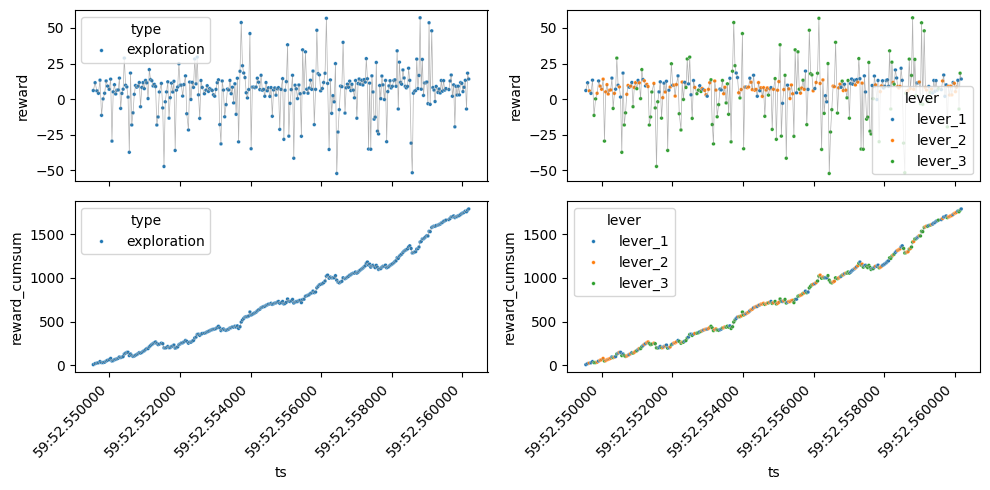

In [11]:
plot_reward(explore_rewarddf)

In [12]:
optimum_reward, actual_reward, regret = get_regret(
    explore_rewarddf, explore_aggdf, n_iterations=300
)

optimum_reward, actual_reward, regret

(3076.8085953227924, 1792.0171423368781, 1284.7914529859142)

## Only Exploitation


In [13]:
def only_exploit(n_iterations, levers):
    rewards = []
    for lever in levers:
        explore([lever], rewards)

    _, _, chosen_lever = get_metrics(exploration_rewards)
    for i in range(n_iterations):
        exploit(chosen_lever, rewards)
    return rewards

In [14]:
exploitation_rewards = only_exploit(
    n_iterations=300, levers=["lever_1", "lever_2", "lever_3"]
)

exploit_rewarddf, exploit_aggdf, _ = get_metrics(exploitation_rewards)

In [15]:
exploit_aggdf

lever          type reward                                                \
                          count          sum        min        max       mean   
0  lever_1  exploitation    300  3006.127094  -3.789541  24.474156  10.020424   
1  lever_1   exploration      1     8.110989   8.110989   8.110989   8.110989   
2  lever_2   exploration      1     7.020875   7.020875   7.020875   7.020875   
3  lever_3   exploration      1   -15.170461 -15.170461 -15.170461 -15.170461   

             
        std  
0  5.174411  
1       NaN  
2       NaN  
3       NaN

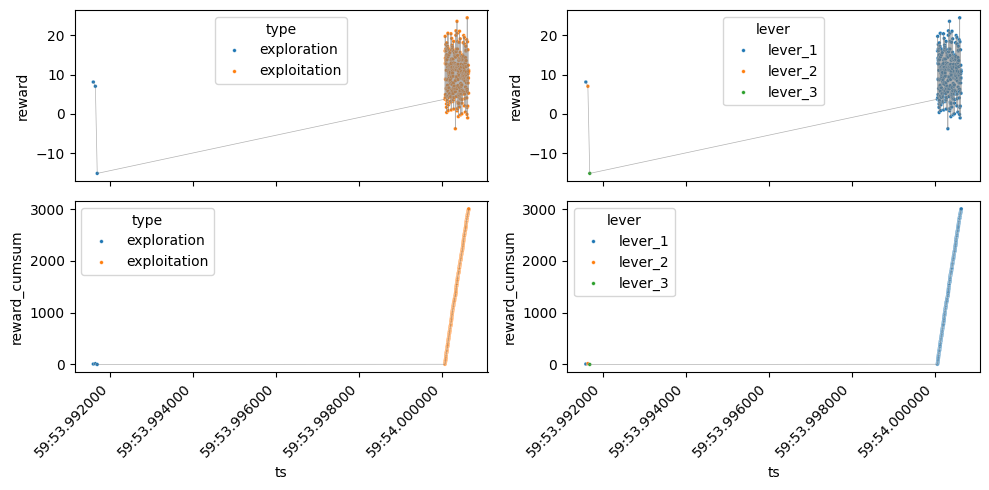

In [16]:
plot_reward(exploit_rewarddf)

In [17]:
optimum_reward, actual_reward, regret = get_regret(
    exploit_rewarddf, exploit_aggdf, n_iterations=300
)
optimum_reward, actual_reward, regret

(3006.1270940000445, 3006.0884968278538, 0.0385971721907481)

## Alternative Exploration & Exploitation


In [18]:
def explore_exploit(
    n_iterations=300,
    explore_iters=10,
    exploit_iters=10,
    levers=["lever_1", "lever_2", "lever_3"],
):
    rewards = []
    run_explore = True

    t_explore_rewards, t_exploit_rewards = [], []
    explore_counter, exploit_counter = 0, 0

    for i in range(n_iterations):
        if run_explore:
            explore(levers, t_explore_rewards)
            explore_counter += 1
        else:
            explore_rewarddf, explore_aggdf, chosen_lever = get_metrics(
                t_explore_rewards
            )
            exploit(chosen_lever, t_exploit_rewards)

            exploit_counter += 1

        if explore_counter == explore_iters:
            rewards.extend(t_explore_rewards)
            t_exploit_rewards.clear()
            run_explore = False
            explore_counter = 0

        if exploit_counter == exploit_iters:
            rewards.extend(t_exploit_rewards)
            t_explore_rewards.clear()
            run_explore = True
            exploit_counter = 0

    return rewards

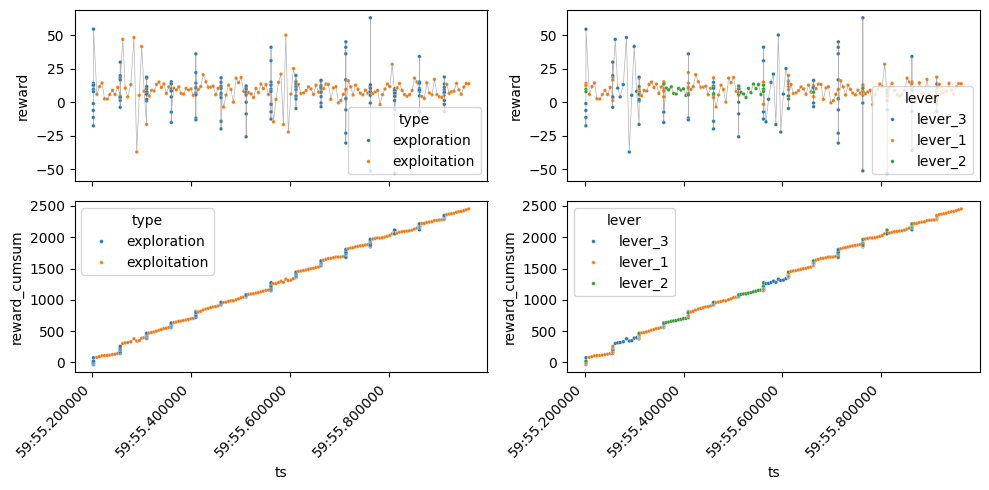

In [19]:
exp_rewards = explore_exploit(
    n_iterations=300,
    explore_iters=10,
    exploit_iters=10,
    levers=["lever_1", "lever_2", "lever_3"],
)
rewarddf, aggdf, _ = get_metrics(exp_rewards)
plot_reward(rewarddf)

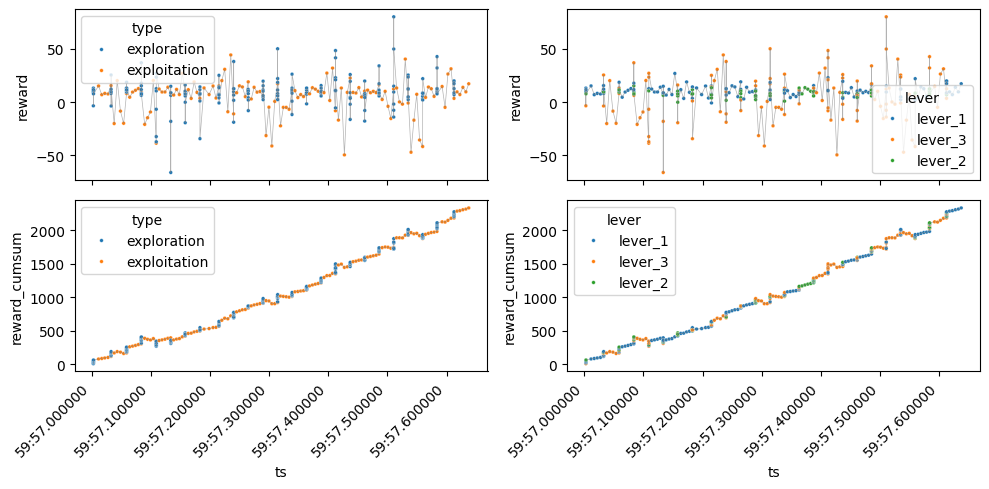

In [20]:
exp_rewards = explore_exploit(
    n_iterations=300,
    explore_iters=7,
    exploit_iters=5,
    levers=["lever_1", "lever_2", "lever_3"],
)
rewarddf, aggdf, _ = get_metrics(exp_rewards)
plot_reward(rewarddf)

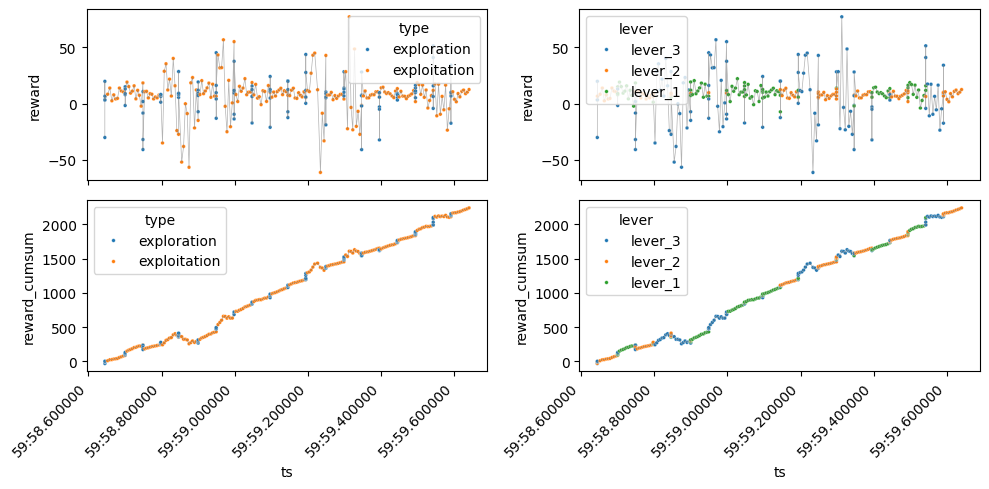

In [21]:
exp_rewards = explore_exploit(
    n_iterations=300,
    explore_iters=5,
    exploit_iters=10,
    levers=["lever_1", "lever_2", "lever_3"],
)
rewarddf, aggdf, _ = get_metrics(exp_rewards)

plot_reward(rewarddf)

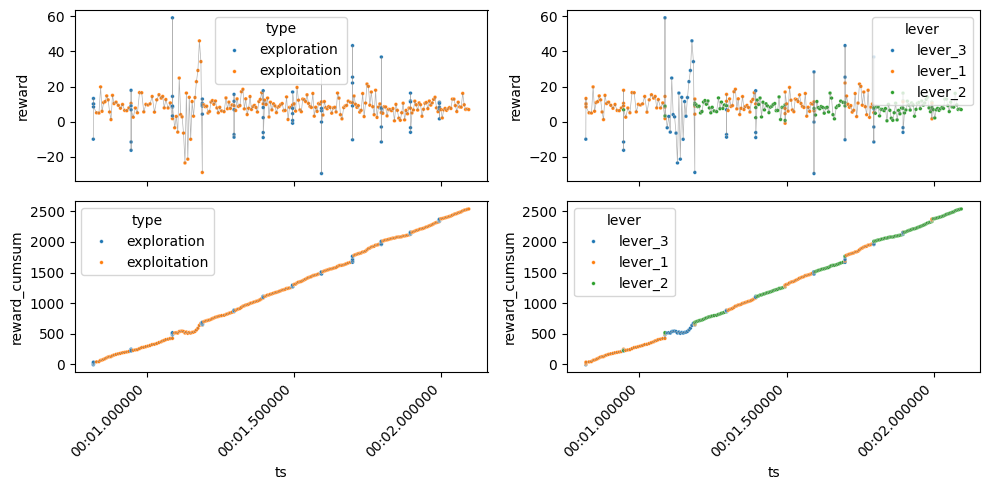

In [22]:
exp_rewards = explore_exploit(
    n_iterations=300,
    explore_iters=5,
    exploit_iters=20,
    levers=["lever_1", "lever_2", "lever_3"],
)
rewarddf, aggdf, _ = get_metrics(exp_rewards)

plot_reward(rewarddf)

## Epsilon($\epsilon$) Greedy